In [39]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

##### ! Run this script cell by cell - the df gets reread into the notebook in certain cells so running the whole script will not work
##### ! Change the path accordingly

Event Ranges with margins before and after

In [61]:
df = pd.read_csv("/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/CertifiedNews_df_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])

events = {
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01")
}


for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

Getting Sentiment Data

In [17]:
event_sentiment_summary = {}
for event in events:
    event_data = df[df[event]]
    non_event_data = df[~df[event]]
    event_avg = event_data["Polarity"].mean()
    non_event_avg = non_event_data["Polarity"].mean()
    event_sentiment_summary[event] = (event_avg, non_event_avg)

# Display the results
for event, (event_avg, non_event_avg) in event_sentiment_summary.items():
    print(f"{event}: During Event Avg Polarity = {event_avg:.3f}, Outside Event Avg Polarity = {non_event_avg:.3f}")


COVID-19 Pandemic: During Event Avg Polarity = 0.209, Outside Event Avg Polarity = 0.136
Ukraine Conflict: During Event Avg Polarity = 0.164, Outside Event Avg Polarity = 0.154
Biden Election Period: During Event Avg Polarity = 0.155, Outside Event Avg Polarity = 0.157
Trump Election Period: During Event Avg Polarity = 0.188, Outside Event Avg Polarity = 0.147
GTA 5 Release: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.155
Snowden Leak: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.155


#### Visualizing Sentiment Data

In [18]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Span, Label, Legend, LegendItem
import pandas as pd

output_notebook()

Loading BokehJS ...

In [19]:
events = {
    # "Event name" : ("start date", "end date", "color 1", "color 2")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01", "#1f77b4", "#aec7e8"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01", "#ff7f0e", "#ffbb78"),
    "Biden Election Period": ("2020-11-01", "2022-01-01", "#2ca02c", "#98df8a"),
    "Trump Election Period": ("2016-11-01", "2020-12-31", "#d62728", "#ff9896"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30", "#9467bd", "#c5b0d5"),
    "Snowden Leak": ("2013-06-01", "2013-07-01", "#8c564b", "#c49c94")
}

for event in events:
    start_date, end_date, start_color, end_color = events[event]
    events[event] = (pd.to_datetime(start_date), pd.to_datetime(end_date), start_color, end_color)


In [22]:
# Create a Bokeh plot
p = figure(title="Sentiment Polarity Over Time with Event Markers",
            x_axis_label="Date", y_axis_label="Polarity",
            x_axis_type="datetime", width=1400, height=600,
            tools="pan,wheel_zoom,box_zoom,reset,save")

# Add a line renderer for daily polarity
p.line(df["Date"], df["Polarity"], legend_label="Daily Polarity", line_width=2, color="blue", alpha=0.5)

# Prepare for legend items
legend_items = []

# Process each event
for event, (start_date, end_date, start_color, end_color) in events.items():
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Add start and end lines using thin lines
    p.line([start_date, start_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=2, color=start_color, legend_label=f"{event} Start")
    p.line([end_date, end_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=2, color=end_color, legend_label=f"{event} End")

# Show the plot
show(p)

## ARIMA

In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [23]:
df = pd.read_csv("/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/CertifiedNews_df_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Assuming "Polarity" is the column with sentiment scores
ts = df["Polarity"]

ARIMA requires the time series to be stationary. 

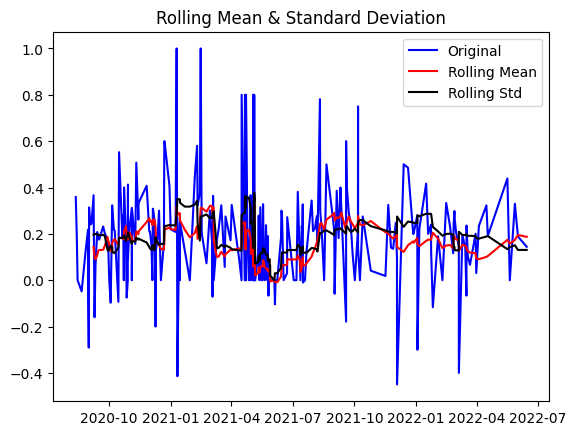

Results of Dickey-Fuller Test:
Test Statistic                  -4.776746
p-value                          0.000060
#Lags Used                       5.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [25]:
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

test_stationarity(ts)

Make the Series Stationary (if needed)

In [ ]:
ts_diff = ts - ts.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Model Selection: determine the ARIMA parameters

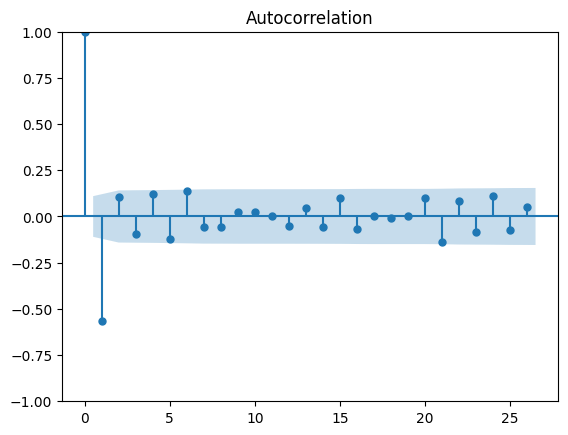

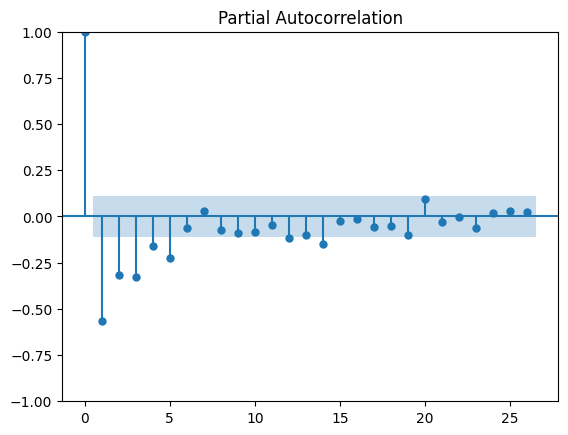

In [28]:
plot_acf(ts_diff)  # To identify the MA(q) order
plot_pacf(ts_diff) # To identify the AR(p) order
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Polarity   No. Observations:                  318
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  36.867
Date:                Sat, 11 May 2024   AIC                            -65.733
Time:                        12:56:18   BIC                            -50.685
Sample:                             0   HQIC                           -59.723
                                - 318                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1556      0.036      4.370      0.000       0.086       0.225
ar.L1          0.9662      0.040     24.339      0.000       0.888       1.044
ma.L1         -0.9159      0.054    -16.854      0.0

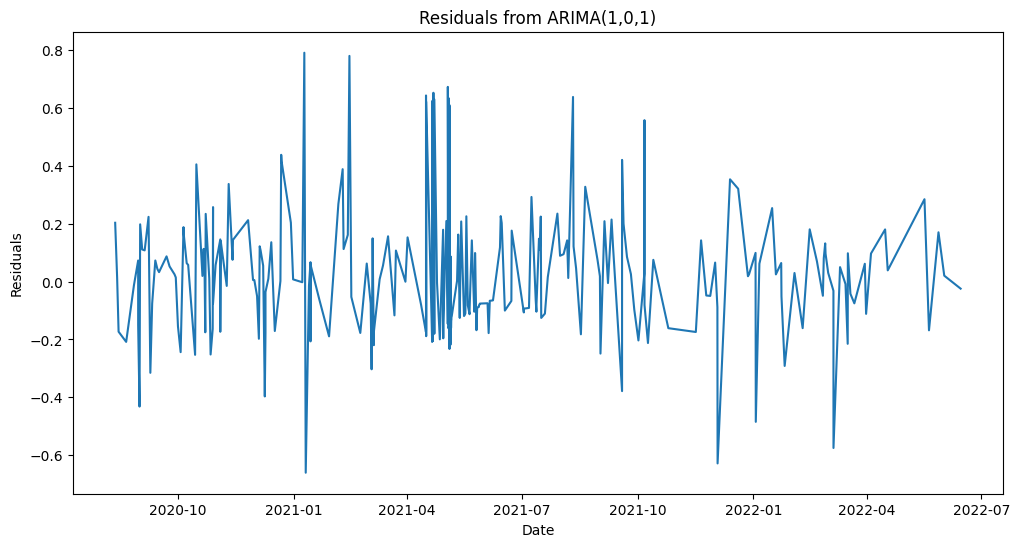

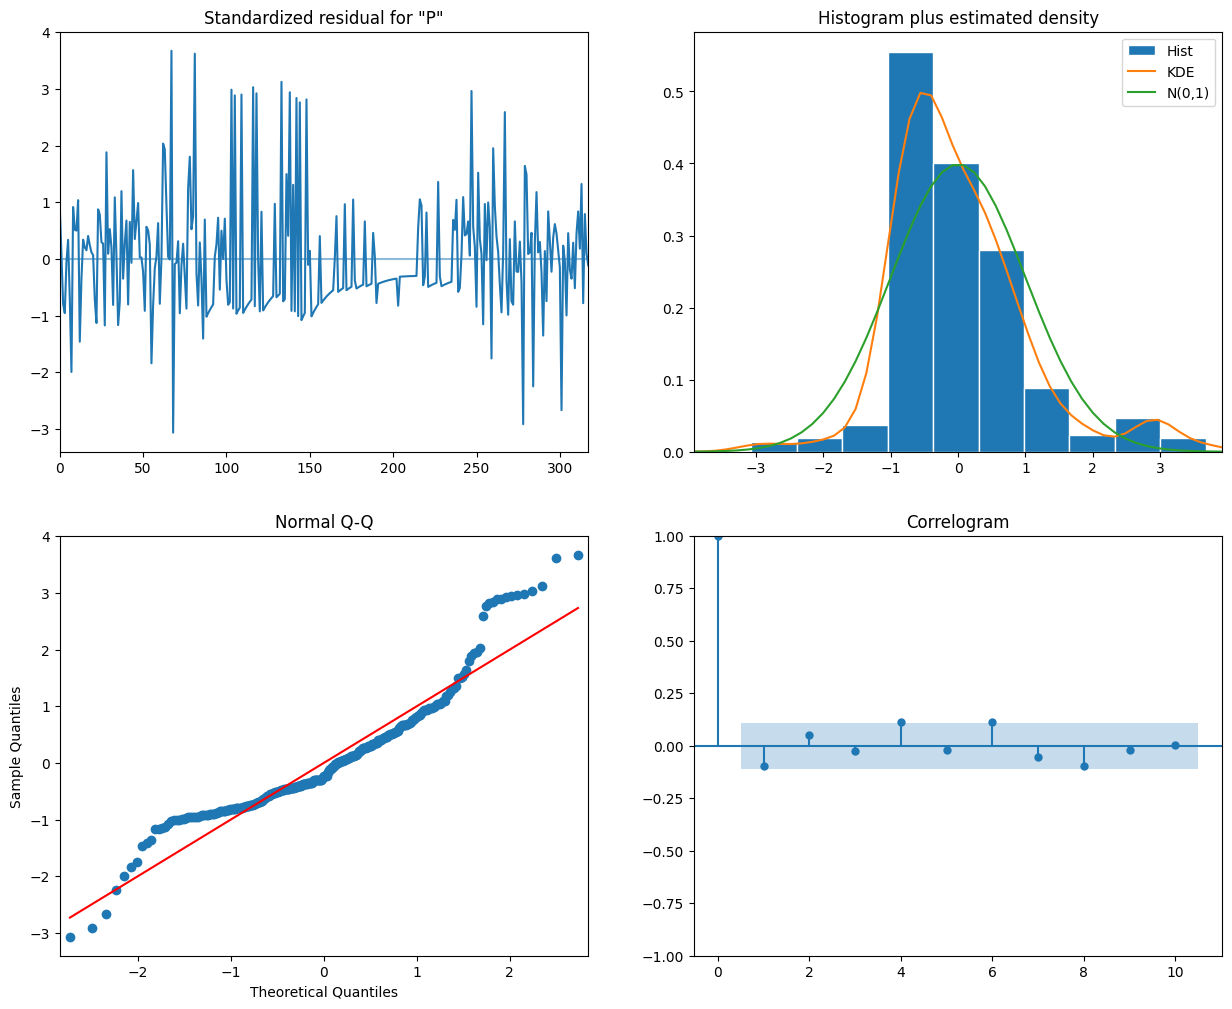

In [31]:
model = ARIMA(ts, order=(1,0,1))  # replace p, d, q with your identified parameters
results = model.fit()
print(results.summary())

residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA(1,0,1)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Optionally, plot diagnostic plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
forecast = results.forecast(steps=10)  # forecast next 10 data points
print(forecast)

318    0.166854
319    0.166474
320    0.166106
321    0.165751
322    0.165408
323    0.165077
324    0.164756
325    0.164447
326    0.164148
327    0.163859
Name: predicted_mean, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Random Forests

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
df = pd.read_csv("/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/CertifiedNews_df_merged.csv")

df["Date"] = pd.to_datetime(df["Date"])

events = {
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01")
}


for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

In [47]:
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df.drop("Date", axis=1, inplace=True)
    
df.dtypes

Text                      object
Polarity                 float64
Subjectivity             float64
COVID-19 Pandemic           bool
Ukraine Conflict            bool
Biden Election Period       bool
Trump Election Period       bool
GTA 5 Release               bool
Snowden Leak                bool
Year                       int32
Month                      int32
Day                        int32
dtype: object

In [54]:
X = df.drop(["Subjectivity", "Text", "COVID-19 Pandemic", "Ukraine Conflict", "Biden Election Period", "Trump Election Period", "GTA 5 Release", "Snowden Leak"], axis=1)
y = df["Polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [56]:
y_pred = regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0003772224480946734
R-squared: 0.9921254140029246


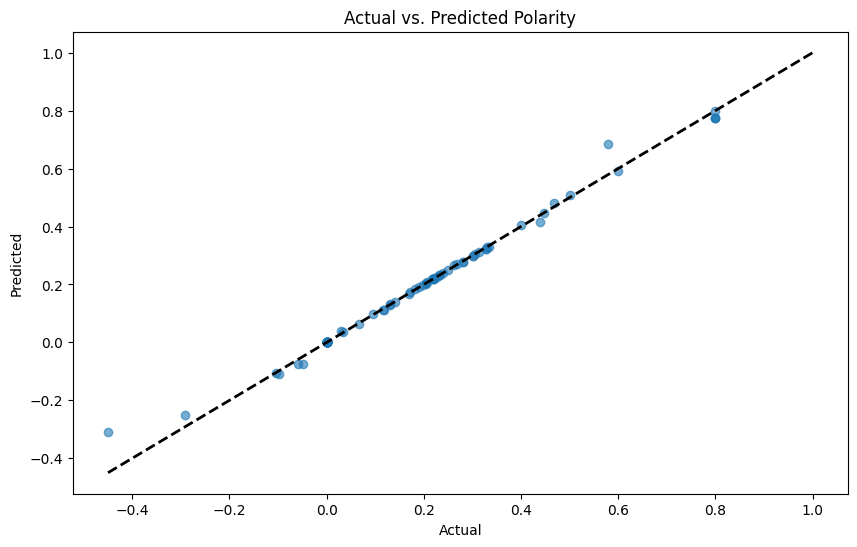

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Polarity')
plt.show()